# Phase-aligned parareal for wave equation. Date: 02/23/2018

The phase-aligned parareal is a parareal scheme equipped with averaged phase and truncation of Fourier modes. Following code shows its numerics and a comparison with plain parareal for homogeneous media. 

Parallel for loop is not used here. Computing time saving will be demonstrated in another notebook.

Loading library for visualization.

In [1]:
using PyPlot

## Problem setup

In [4]:
dX=0.06;
X=collect(-2:dX:2); 
Y=X[:];
Nx=size(X,1);
Ny=size(Y,1);
k=pi;
u0=[exp(1im*k*i-4*(i^2)-1*(j^2)) for i in X, j in Y];
ut0=complex(zeros(Ny,Nx));
vel=ones(size(ut0));
println("Number of grids per wavelength is ",2*pi/(k*dX))

Number of grids per wavelength is 33.333333333333336


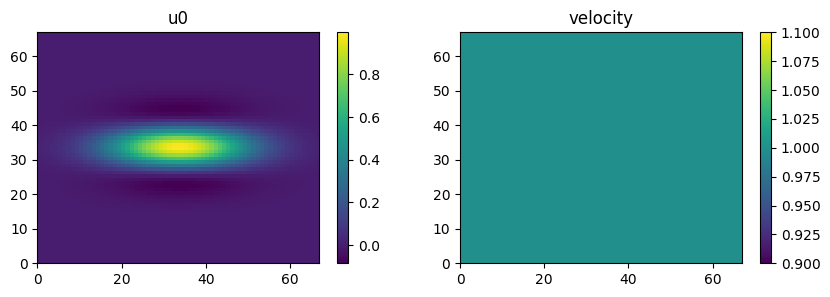

PyObject <matplotlib.colorbar.Colorbar object at 0x000000004A03B278>

In [45]:
figure(figsize=(10.0,3.0))
subplot(1,2,1);pcolormesh(real(u0));title("u0")
colorbar()
subplot(1,2,2);pcolormesh(vel);title("velocity")
colorbar()

## Include solvers and interpolation functions

In [6]:
#include("wave_abc2.jl")    # Finite difference with absorbing BC.
include("wave2.jl")    # Finite difference with periodic BC. Time step is dt=dx/2.

wave2 (generic function with 1 method)

In [7]:
function fourier2interp(a,m)
    # 2D Fourier interpolation with m-time more grids.
    # Interpolating by padding zeros to high Fourier domains, and then using inverse-FFT to transform back to spatial domain.
    Nrow=size(a,1);
    Ncol=size(a,2);
    aff =fft(a,[1,2]);
    
    interpmat=complex(zeros(m*(Nrow-1)+1,m*(Ncol-1)+1));
    intfrow_half=Int(floor(Nrow/2));
    intfcol_half=Int(floor(Ncol/2));
    
    interpmat[1:intfrow_half,1:intfcol_half]=aff[1:intfrow_half,1:intfcol_half];
    interpmat[1:intfrow_half,(m-1)*(Ncol-1)+intfcol_half+1:end]=aff[1:intfrow_half,intfcol_half+1:end];
    interpmat[(m-1)*(Nrow-1)+intfrow_half+1:end,1:intfcol_half]=aff[intfrow_half+1:end,1:intfcol_half];
    interpmat[(m-1)*(Nrow-1)+intfrow_half+1:end,(m-1)*(Ncol-1)+intfcol_half+1:end]=aff[intfrow_half+1:end,intfcol_half+1:end];
    
    return ifft(interpmat,[1,2])*((Nrow-1)*m+1)*((Ncol-1)*m+1)/(Nrow*Ncol);
end

function fourier2samp(a,m)
    # 2D Fourier downsampling with m-time less grids.
    # Downsampling by removing high frequency modes, then using inverse-FFT to transform back to spatial domain.
    Nrow=size(a,1);
    Ncol=size(a,2);
    aff =fft(a,[1,2]);
    
    samplemat=complex(zeros(Int(floor(Nrow/m))+1,Int(floor(Ncol/m))+1));
    
    intfrow_half=Int(floor(Nrow/(2*m)));
    intfcol_half=Int(floor(Ncol/(2*m)));
    
    samplemat[1:intfrow_half,1:intfcol_half] = aff[1:intfrow_half,1:intfcol_half];
    samplemat[1:intfrow_half,intfcol_half+1:end] = aff[1:intfrow_half,Ncol-intfcol_half:end];
    samplemat[intfrow_half+1:end,1:intfcol_half] = aff[Nrow-intfrow_half:end,1:intfcol_half];
    samplemat[intfrow_half+1:end,intfcol_half+1:end] = aff[Nrow-intfrow_half:end,Ncol-intfcol_half:end];
    
    return ifft(samplemat,[1,2])*((Nrow-1)/m+1)*((Ncol-1)/m+1)/(Nrow*Ncol);
end

fourier2samp (generic function with 1 method)

## Test solver and interpolation functions

In [8]:
Tfin=5;
u,ut=wave2(u0,ut0,vel,dX,Tfin);

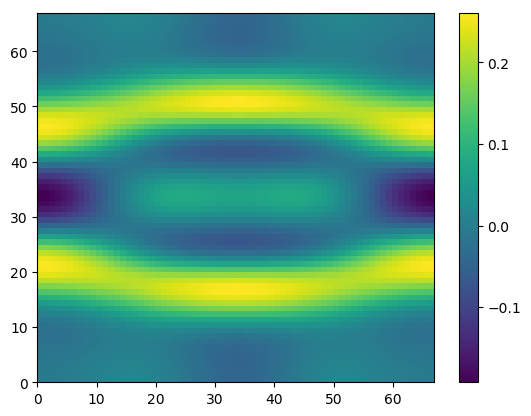

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000028FBB278>

In [9]:
pcolormesh(real.(u))
colorbar()

Try smaller grid

In [10]:
m=3;
dx=dX/m;

# Need to interpolation initial wavefield u0 as well as velocity field
u4f = fourier2interp(u0,m);            
ut4f = fourier2interp(ut0,m);
vel4f = fourier2interp(vel,m);

u_fine,ut_fine = wave2(u4f,ut4f,vel4f,dx,Tfin);

# Downsample solution
finesol = fourier2samp(u_fine,m);         
finesolt = fourier2samp(ut_fine,m); 

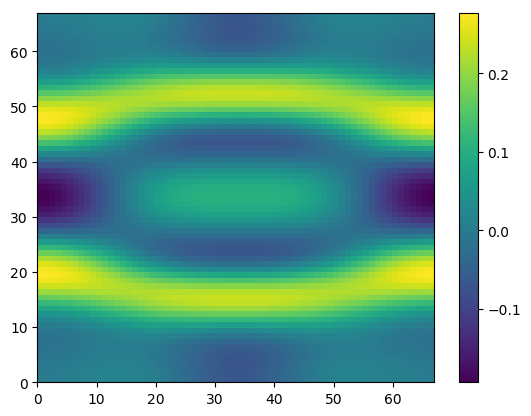

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000029394CC0>

In [11]:
pcolormesh(real.(finesol))
colorbar()

## Parareal function

Now we define the plain parareal function:
1. In parallel processors, $F u^{k}_{n}$ and $C u^{k}_{n}$ are computed on k-iterated solution at time $n$.
2. Serially compute $u^{k+1}_{n+1} = C u^{k+1}_{n} + (F u^{k}_{n} - C u^{k}_{n})$ where the term in parenthese has been parallel computed in step 1.


where C, F are coarse and fine solvers. Parareal iteration is denoted by $k$ and time-stepping is $n$.

In [37]:
function wave2_plainparareal(u0,ut0,vel,dX,pimax)
    # plain parareal scheme for wave equation
    t_final = 24;
    dT = 0.06;
    m = 3;
    dx = dX/m;
    
    time = collect(0:dT:t_final);
    Nt = size(time,1);
    Nx = size(u0,2);
    Ny = size(u0,1);
    
    u  = complex(zeros(Ny,Nx,Nt));
    ut = complex(zeros(Ny,Nx,Nt));
    
    finesol = complex(zeros(Ny,Nx,Nt));
    finesolt = complex(zeros(Ny,Nx,Nt));
    coarsesol= complex(zeros(Ny,Nx,Nt));
    coarsesolt= complex(zeros(Ny,Nx,Nt));
    
    u[:,:,1]  = u0[:,:];
    ut[:,:,1] = ut0[:,:];
    
    # initial parareal guess
    for i=2:Nt
        u[:,:,i],ut[:,:,i]=wave2(u[:,:,i-1],ut[:,:,i-1],vel,dX,dT);
    end
    
    for pri=1:pimax   # parareal iteration
        
        # PARALLEL COMPUTATION
        for i=2:Nt
            u4f = fourier2interp(u[:,:,i-1],m);            
            ut4f = fourier2interp(ut[:,:,i-1],m);
            vel4f = fourier2interp(vel,m);
            u_fine,ut_fine = wave2(u4f,ut4f,vel4f,dx,dT);
            
            finesol[:,:,i]  = fourier2samp(u_fine,m);         
            finesolt[:,:,i]  = fourier2samp(ut_fine,m);   
            
            coarsesol[:,:,i],coarsesolt[:,:,i] = wave2(u[:,:,i-1],ut[:,:,i-1],vel,dX,dT);       
        end
        
        # SERIAL UPDATE
        for i=2:Nt
            us,uts=wave2(u[:,:,i-1],ut[:,:,i-1],vel,dX,dT);
            
            u[:,:,i] = us+finesol[:,:,i]-coarsesol[:,:,i];
            ut[:,:,i]= uts+finesolt[:,:,i]-coarsesolt[:,:,i];           
        end      
        
    end    
    
    return (u,ut)
    
end

wave2_plainparareal (generic function with 1 method)

Phase-aligned parareal function is defined. Let $\theta$ be the phase-alignement coefficient and have same dimension as $u_0$ and $\theta^{k=1}=1$. Frequency truncation $s$ also has same dimension as $u_0$.
1. As in plain parareal, in parallel processors, $F u^{k}_{n}$ and $C u^{k}_{n}$ are computed on k-iterated solution at time $n$.
2. Compute angle in complex plane between $\mathcal{F} F u^{k}_{n}$ and $\mathcal{F} C u^{k}_{n}$ at each time step. Average with respect to time $n$, denoted $\bar{\phi}$.
3. Frequency truncation is $s = s+[|\mathcal{F} F u^{k}_{n}|\geq \epsilon \max_{\xi}|\mathcal{F} F u^{k}_{n}|]$ over $n$. 
4. Compute phase-alignment coefficient $\theta=\exp^{i\bar{\phi}}\times [s>\sigma]$.
5. In serial, $ u^{k+1}_{n+1} = \mathcal{F}^{-1} (\theta \mathcal{F} C u^{k+1}_{n} + \mathcal{F} F u^{k}_{n} - \theta \mathcal{F} C u^{k}_{n} )$.

Notation $[]$ is conditional indicator function. Threshold parameters $\epsilon$,$\sigma$ control stability and accuracy of the scheme. 

In [26]:
function wave2_phaseparareal(u0,ut0,vel,dX,pimax)
    t_final = 24;
    dT = 0.06;
    time = collect(0:dT:t_final);
    Nt = size(time,1);
    Nx = size(u0,2);
    Ny = size(u0,1);
    
    u  = complex(zeros(Ny,Nx,Nt));
    ut = complex(zeros(Ny,Nx,Nt));
    
    u[:,:,1]  = u0[:,:];
    ut[:,:,1] = ut0[:,:];
    
    m = 3;
    dx = dX/m;
    
    # initial parareal guess
    for i=2:Nt
        u[:,:,i],ut[:,:,i]=wave2(u[:,:,i-1],ut[:,:,i-1],vel,dX,dT);
    end
    
    # parareal iteration
    finesol = complex(zeros(Ny,Nx,Nt));
    finesolt = complex(zeros(Ny,Nx,Nt));
    coarsesol= complex(zeros(Ny,Nx,Nt));
    coarsesolt= complex(zeros(Ny,Nx,Nt));

    cfupdate=complex(zeros(Ny,Nx,Nt));
    cftupdate=complex(zeros(Ny,Nx,Nt));
    cgft=complex(ones(Ny,Nx));  # \theta 
    cgtft=complex(ones(Ny,Nx));   # \theta for time derivative
    
    for pri=1:pimax
        
        # PARALLEL COMPUTATION
        for i=2:Nt
            u4f = fourier2interp(u[:,:,i-1],m);            
            ut4f = fourier2interp(ut[:,:,i-1],m);
            vel4f = fourier2interp(vel,m);
            u_fine,ut_fine = wave2(u4f,ut4f,vel4f,dx,dT);
            
            finesol[:,:,i]  = fourier2samp(u_fine,m);         
            finesolt[:,:,i]  = fourier2samp(ut_fine,m);   
            
            coarsesol[:,:,i],coarsesolt[:,:,i] = wave2(u[:,:,i-1],ut[:,:,i-1],vel,dX,dT);       
        end
        
        g_ft=complex(zeros(Ny,Nx));    # store averaged angles
        gt_ft=complex(zeros(Ny,Nx));       
        supportcgft=zeros(Ny,Nx);    # frequency truncation
        
        for i=2:Nt    # compute angles and support in step 2 and step 3
            ffine = fft(finesol[:,:,i],[1,2]);
            ffinet= fft(finesolt[:,:,i],[1,2]);
            fcoarse=conj(cgft).*fft(coarsesol[:,:,i],[1,2]);
            fcoarset=conj(cgtft).*fft(coarsesolt[:,:,i],[1,2]);
            
            alpha=(angle.(conj(ffine).*fcoarse));
            betaa=(angle.(conj(ffinet).*fcoarset));
            g_ft=g_ft+(alpha-g_ft)/(i-1);
            gt_ft=gt_ft+(betaa-gt_ft)/(i-1); 
            
            # epsilon is 1e-3
            supportcgft=supportcgft+
                    convert(Array{Int},((abs.(ffine)+abs.(ffinet))/maximum((abs.(ffine)+abs.(ffinet)))).>1e-3);
                
        end
        
        # compute \theta in step 4, sigma is 0.3
        cgft=(exp.(im*g_ft).*cgft).*convert(Array{Int},abs.(supportcgft)/maximum(abs.(supportcgft)).>0.3);
        cgtft=(exp.(im*gt_ft).*cgtft).*convert(Array{Int},abs.(supportcgft)/maximum(abs.(supportcgft)).>0.3);
        
        # SERIAL UPDATE
        for i=2:Nt
            us,uts=wave2(u[:,:,i-1],ut[:,:,i-1],vel,dX,dT);
            
            ffine = fft(finesol[:,:,i],[1,2]);
            ffinet= fft(finesolt[:,:,i],[1,2]);
            fcoarse=conj(cgft).*fft(coarsesol[:,:,i]);
            fcoarset=conj(cgtft).*fft(coarsesolt[:,:,i]);
            fs=conj(cgft).*fft(us,[1,2]);
            fst=conj(cgtft).*fft(uts,[1,2]);
            
            cfupdate[:,:,i] = ffine-fcoarse;
            cftupdate[:,:,i]= ffinet-fcoarset;
            u[:,:,i] = ifft(fs+cfupdate[:,:,i],[1,2]);
            ut[:,:,i]= ifft(fst+cftupdate[:,:,i],[1,2]);
            
        end      
        
    end    
    
    return (u,ut,cgft,finesol,coarsesol)
    
end

wave2_phaseparareal (generic function with 1 method)

## Test parareal function

In [27]:
u1,ut1=wave2_plainparareal(u0,ut0,vel,dX,0);

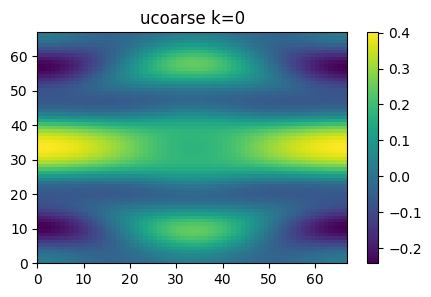

PyObject <matplotlib.colorbar.Colorbar object at 0x000000006BD12DA0>

In [51]:
figure(figsize=(5,3))
pcolormesh(real.(u1[:,:,end]));title("ucoarse k=0")
colorbar()

### Compute full fine scale solution

In [29]:
m=3;
dx=dX/m;

u4f = fourier2interp(u0,m);
ut4f = fourier2interp(ut0,m);
velf = fourier2interp(vel,m);

ub,utb=wave2_plainparareal(u4f,ut4f,velf,dx,0);

ubdown = complex(zeros(Ny,Nx,size(ub,3)))
utbdown = complex(zeros(Ny,Nx,size(utb,3)))

for i=1:size(ub,3)   
    ubdown[:,:,i]  = fourier2samp(ub[:,:,i],m)
    utbdown[:,:,i]  = fourier2samp(utb[:,:,i],m)  
end

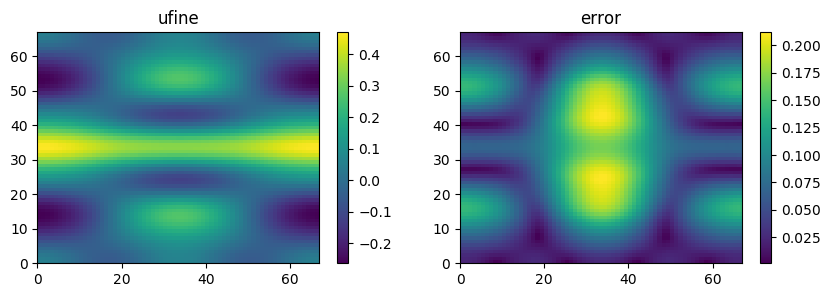

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000609BC470>

In [48]:
figure(figsize=(10,3))
subplot(1,2,1);
pcolormesh(real.(ubdown[:,:,end]));title("ufine")
colorbar()
subplot(1,2,2);
pcolormesh(abs.(u1[:,:,end]-ubdown[:,:,end]));title("error")
colorbar()

## Numerical comparison of parareal algorithms

Following codes will take couple minutes to finish. Another numerical result is presented at the end. 

In [32]:
u2,ut2=wave2_phaseparareal(u0,ut0,vel,dX,2);
u3,ut3=wave2_phaseparareal(u0,ut0,vel,dX,5);
u4,ut4=wave2_phaseparareal(u0,ut0,vel,dX,10);

In [38]:
u2n,ut2n=wave2_plainparareal(u0,ut0,vel,dX,2);
u3n,ut3n=wave2_plainparareal(u0,ut0,vel,dX,5);
u4n,ut4n=wave2_plainparareal(u0,ut0,vel,dX,10);

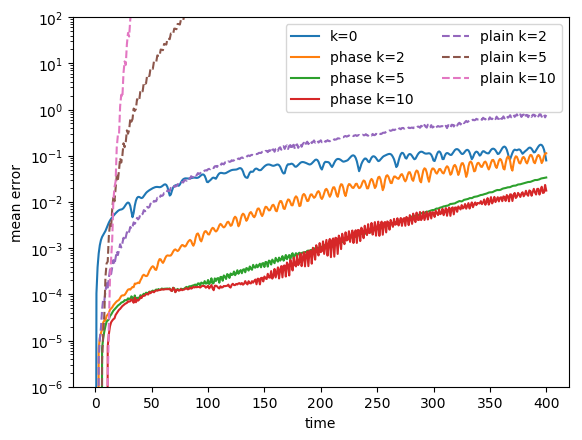

(1.0e-6, 100.0)

In [41]:
meanerr1=[mean(abs.(u1[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u1,3))];  # initial guess k=0
meanerr2=[mean(abs.(u2[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u2,3))];
meanerr3=[mean(abs.(u3[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u3,3))];
meanerr4=[mean(abs.(u4[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u4,3))];
semilogy(meanerr1)
semilogy(meanerr2)
semilogy(meanerr3)
semilogy(meanerr4)
meanerr2n=[mean(abs.(u2n[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u2n,3))];
meanerr3n=[mean(abs.(u3n[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u3n,3))];
meanerr4n=[mean(abs.(u4n[:,:,s]-ubdown[:,:,s])) for s in range(1,size(u4n,3))];
semilogy(meanerr2n,linestyle="--")
semilogy(meanerr3n,linestyle="--")
semilogy(meanerr4n,linestyle="--")

xlabel("time")
ylabel("mean error")

legend(["k=0","phase k=2","phase k=5","phase k=10","plain k=2","plain k=5","plain k=10"],loc="upper right",ncol=2)
ylim([1e-6,1e2])

An example when fine solver is 4 times resolved than coarse (m=4), $dX=0.04$,$dx=0.01$,$dT=0.04$,$T_{final}=20$.
<img src="parareal2d_comparison_xlim500.png"/>

Zooming down first few time steps
<img src="parareal2d_comparison_xlim20.png"/>